In [1]:
import torch
import torchaudio as ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ffmpeg
import IPython
import librosa
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
ta.set_audio_backend("sox_io")

In [2]:
import python_speech_features as sf

Detections are in s, labels are in in ms

In [3]:
number = 12
data_paths = './dataset/'
data_path = data_paths + "voice/s{}.m4a".format(number)
data_path_out = data_paths + "voice/s{}.wav".format(number)
labels_path = data_paths + "key_and_time/s{}.txt".format(number)
detections_path = data_paths + "detections/s{}.txt".format(number)

In [4]:
waveform, sample_rate = ta.load(data_path_out)
labels = pd.read_csv(labels_path, delimiter="\"", header=0, usecols=[3, 7], \
                          names=['key', 'time']).dropna()
detections = pd.read_csv(detections_path, index_col=0)
labels['time'] /= 1000

In [5]:
detections = pd.read_csv(detections_path, index_col=0)
labels = pd.read_csv(labels_path, delimiter="\"", header=0, usecols=[3, 7], \
                          names=['key', 'time']).dropna()

In [6]:
detections['start sample'] = detections['start'] * sample_rate
detections

,start,stop,start sample
0,0.443125,0.523125,21270.0
1,0.832292,0.912292,39950.0
2,0.970208,1.050208,46570.0
3,1.195208,1.275208,57370.0
4,1.366458,1.446458,65590.0
...,...,...,...
274,61.847292,61.927292,2968670.0
275,62.148958,62.228958,2983150.0
276,62.296042,62.376042,2990210.0
277,62.468958,62.548958,2998510.0


In [7]:
da_features = []
da_labels = []
seq_lens = []
for number in range(12):
    d_set_size = 0
    data_paths = './dataset/'
    data_path = data_paths + "voice/s{}.m4a".format(number)
    data_path_out = data_paths + "voice/s{}.wav".format(number)
    labels_path = data_paths + "key_and_time/s{}.txt".format(number)
    labels = pd.read_csv(labels_path, delimiter="\"", header=0, usecols=[3, 7], \
                          names=['key', 'time']).dropna()
    labels['time_sample'] = labels['time']/1000 * sample_rate
    detections_path = data_paths + "detections/s{}.txt".format(number)
    detections = pd.read_csv(detections_path, index_col=0)
    detections['start_sample'] = detections['start'] * sample_rate
    detections['stop_sample'] = detections['stop'] * sample_rate
    for i in range(len(detections)):
        # get nearest label in time
        start = detections['start'][i]*1000
        labels['dist_to_start'] = abs(labels['time'] - start)
        min_idx = labels['dist_to_start'].idxmin()
        label = labels['key'][min_idx]
        
        start_sample = detections['start_sample'][i]
        stop_sample = detections['stop_sample'][i]
        keypress = np.array(waveform[:, int(start_sample):int(stop_sample)])
        length = int(stop_sample - start_sample)
        n_mels = 20
        #features = librosa.feature.mfcc(y=keypress, sr=sample_rate, n_mfcc=n_mels, hop_length=length)
        features = np.array(sf.mfcc(keypress,sample_rate,0.01, 0.0025, 32, 32, preemph=0, highfreq=12000, ceplifter=0,
                       appendEnergy=False))
        # TODO make sure feature vectors are all the same size
        if features.shape == (29, 32):
            da_features.append(features.flatten())
            da_labels.append(label)
            d_set_size += 1
        else: 
            print('fail')
            print(features.shape)
    seq_lens.append(d_set_size)
length = np.sum(seq_lens)
da_features = np.array(da_features).reshape(length, -1)

fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(30, 32)
fail
(

In [8]:
da_features.shape

(2442, 928)

In [9]:
da_labels = pd.DataFrame(da_labels, columns=['true label'])
#da_labels.value_counts()

## Splitting into datasets (train and val)

In [10]:
n_samples = da_features.shape[0]
X_train = da_features[:int(.8*n_samples), :]
y_train = da_labels[:int(.8*n_samples)]
X_val = da_features[int(.8*n_samples):, :]
y_val = da_labels[int(.8*n_samples):]

## K-Means Clustering, get distace from each cluster

In [11]:
kmeans = KMeans(n_clusters=50, random_state=0, n_init="auto").fit(X_train)
y_val['pred'] = kmeans.predict(X_val)
y_train['pred'] = kmeans.predict(X_train)

/var/folders/1y/3mt7fkvd4s1bm0m2bp4fqyh00000gn/T/ipykernel_13578/2470847204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val['pred'] = kmeans.predict(X_val)
/var/folders/1y/3mt7fkvd4s1bm0m2bp4fqyh00000gn/T/ipykernel_13578/2470847204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['pred'] = kmeans.predict(X_train)


In [12]:
pca = sklearn.decomposition.PCA(n_components=3)

In [13]:
X_transformed = pca.fit_transform(X_train)
centroids_trans = pca.transform(kmeans.cluster_centers_)

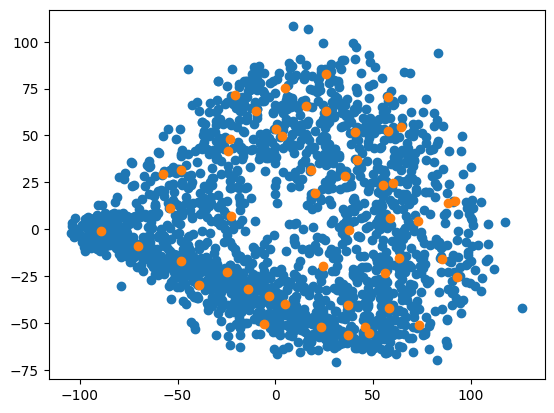

In [14]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])
plt.scatter(centroids_trans[:, 0], centroids_trans[:, 1])

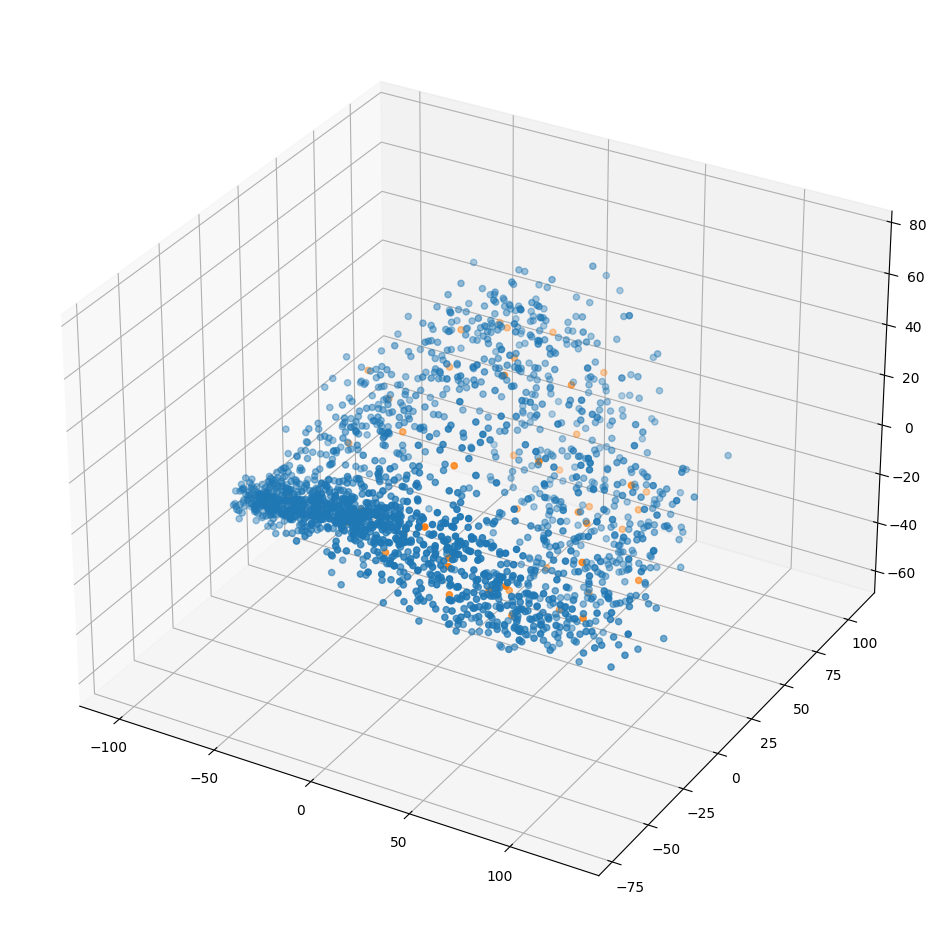

In [15]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2])
ax.scatter(centroids_trans[:, 0], centroids_trans[:, 1], centroids_trans[:, 2], 'r')
plt.show()

In [16]:
centers = kmeans.cluster_centers_

Get distance between datapoint and cluster centroids

In [65]:
X_train = da_features

In [66]:
distanced_data = np.zeros([X_train.shape[0], centers.shape[0]])
for i in range(distanced_data.shape[0]):
    for j in range(distanced_data.shape[1]):
        distanced_data[i, j] = np.linalg.norm(X_train[i, :] - centers[j, :])

In [67]:
distanced_data.shape

(2442, 50)

## Trying a HMM
Need to split data into sequences first

In [77]:
from hmmlearn import hmm

In [78]:
np.sum(seq_lens)

2442

In [79]:
sequences = []
set_length_to = 20
idx = 0
for seq in seq_lens:
    num_lens = seq // set_length_to
    remainder = seq % set_length_to
    for i in range(num_lens):
        sequences.append(distanced_data[idx:idx+set_length_to, :])
        idx += set_length_to
    idx += remainder
sequences = np.array(sequences)

In [80]:
sequences.shape

(115, 20, 50)

Fetch bigram from tale of two cities

In [20]:
from numpy import genfromtxt
bigram = genfromtxt('./ECE324_Project_HMM/bigram.csv', delimiter=',')

In [21]:
bigram.shape

(27, 27)

In [82]:
dX_train.shape

(1953, 50)

In [139]:
n_components = 27
alphabet_length = 27
model = hmm.GMMHMM(n_components=n_components, 
                   transmat_prior=bigram,
                   n_mix=alphabet_length, 
                   covariance_type="full", 
                   algorithm="viterbi", verbose=True)

In [140]:
lengths = [10] * sequences.shape[0]
X_train = sequences.reshape(-1, sequences.shape[2])

In [83]:
dX_train.shape

(1953, 50)

In [144]:
model.fit(X_train, lengths)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 295999 free scalar parameters with only 67500 data points will result in a degenerate solution.
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: Fu

         1     -118942.2148             +nan
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/hmmlearn/hmm.py:1238: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
         2      -20127.8364      +98814.3784


ValueError: array must not contain infs or NaNs

In [ ]:
model.predict(X_train[0:20, :])

## Training Random Forest for Proof of Concept

model is on da_features, raw from MFCC,

dmodel is on the K-means cluster distances (clusters created from the training data only).

In [58]:
da_features.shape

(2442, 928)

In [68]:
distanced_data.shape

(2442, 50)

In [69]:
n_samples = da_features.shape[0]
X_train = da_features[:int(.8*n_samples), :]
y_train = da_labels[:int(.8*n_samples)]
X_val = da_features[int(.8*n_samples):, :]
y_val = da_labels[int(.8*n_samples):]

dX_train = distanced_data[:int(.8*n_samples), :]
dy_train = da_labels[:int(.8*n_samples)]
dX_val = distanced_data[int(.8*n_samples):, :]
dy_val = da_labels[int(.8*n_samples):]

In [70]:
dX_val

array([[ 30.0932365 , 168.85188087, 112.81072403, ..., 145.86193898,
        116.25866244, 146.31657812],
       [ 84.06260887, 111.24944195,  99.21744304, ...,  80.47697262,
        124.08140453, 117.24524969],
       [100.69949467, 123.21221764,  63.73018059, ..., 107.61973766,
         81.61081987,  83.45845491],
       ...,
       [ 34.84208689, 165.32046129, 113.80644583, ..., 138.32672079,
        113.96409025, 142.07044492],
       [ 29.32864586, 180.58740837, 127.90255143, ..., 154.47805078,
        125.02493531, 158.14629101],
       [ 34.15310066, 192.47665958, 135.43644731, ..., 165.24447243,
        127.56899077, 165.31753083]])

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
model = RandomForestClassifier()
dmodel = RandomForestClassifier(n_estimators=400)

In [27]:
dmodel.fit(dX_train, dy_train['true label'].to_numpy().flatten())

RandomForestClassifier(n_estimators=400)

In [28]:
print(classification_report(dy_val['true label'].to_numpy().flatten(), dmodel.predict(dX_val)))

NameError: name 'classification_report' is not defined

In [249]:
model.fit(X_train, y_train['true label'].to_numpy().flatten())

RandomForestClassifier()

In [267]:
print(classification_report(y_val['true label'].to_numpy().flatten(), model.predict(X_val)))

              precision    recall  f1-score   support

                   0.12      0.68      0.20        59
           a       0.20      0.03      0.05        36
           b       0.00      0.00      0.00         1
           c       0.00      0.00      0.00        13
           d       0.00      0.00      0.00        22
           e       0.07      0.08      0.07        52
           f       0.00      0.00      0.00        14
           g       0.00      0.00      0.00        14
           h       0.00      0.00      0.00        19
           i       0.21      0.09      0.13        44
           l       0.00      0.00      0.00        16
           m       0.00      0.00      0.00         8
           n       0.03      0.03      0.03        30
           o       0.00      0.00      0.00        30
           p       0.00      0.00      0.00         5
           q       0.00      0.00      0.00         1
           r       0.00      0.00      0.00        28
           s       0.00    

/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [250]:
dmodel.predict(dX_val)

array(['g', ' ', 's', 'i', 'o', ' ', ' ', 'r', 'f', 'p', 'n', 'i', 'd',
       ' ', 'i', 'a', 's', 's', 'a', ' ', 'g', 'h', 'n', 'e', 'i', 'i',
       'n', 'n', 'e', 'i', ' ', 'e', 'n', 'n', 'o', 'u', 'e', ' ', 's',
       'm', 'c', 'n', 'r', ' ', 'o', 'r', 'a', 'e', 'd', ' ', ' ', 'l',
       't', 's', 'o', 'e', 'u', 's', 'e', ' ', 'e', ' ', ' ', 's', 's',
       'e', 'n', 'n', ' ', 'n', 'r', 'o', 'a', 'e', 'r', ' ', ' ', 'a',
       'a', 'l', 'h', 'e', 'e', 'l', 'n', ' ', ' ', 's', 'd', 'o', ' ',
       'f', 'h', 'f', 'g', 'n', 'e', ' ', ' ', 'e', 'f', 'e', 'f', 't',
       's', 'e', 'e', 'e', 't', ' ', 'n', 'g', 'i', ' ', 'd', ' ', 'n',
       ' ', ' ', ' ', ' ', 'n', ' ', 'v', 'c', ' ', 't', 'a', ' ', ' ',
       'h', ' ', 'e', 's', 'l', 'o', 'a', 'e', 'r', 'r', ' ', 'n', ' ',
       'n', 'h', ' ', 'n', 't', 't', 'e', 's', 'e', ' ', 'v', 'e', 'n',
       'e', 'i', 'g', 'i', ' ', 'e', 'o', 'w', ' ', 'i', 's', 's', 'f',
       't', 'i', 'e', 'n', 't', 't', 'e', 'h', ' ', 'a', ' ', 's

In [71]:
dmodel.score(dX_val, dy_val)

0.08384458077709611

In [48]:
from sklearn.feature_selection import RFECV

In [72]:
classifier = sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=500, n_jobs=4)
selector = sklearn.feature_selection.RFECV(classifier, step=int(dX_train.shape[1] / 10), cv=5, verbose=0)
selector = selector.fit(dX_train, dy_train['true label'].to_numpy().flatten())     

In [73]:
selector.score(dX_val, dy_val['true label'].to_numpy().flatten())

0.11247443762781185

In [75]:
classifier2 = sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=300, n_jobs=4)
#selector2 = sklearn.feature_selection.RFECV(classifier2, step=int(X_train.shape[1] / 10), cv=5, verbose=0)
selector2 = classifier2.fit(X_train, y_train['true label'].to_numpy().flatten())     

In [76]:
selector2.score(X_val, y_val['true label'].to_numpy().flatten())

0.08588957055214724

/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [262]:
1/27


0.037037037037037035

In [263]:
from sklearn.metrics import classification_report

In [265]:
print(classification_report(y_val['true label'].to_numpy().flatten(), selector2.predict(X_val)))

              precision    recall  f1-score   support

                   0.12      0.98      0.22        59
           a       0.00      0.00      0.00        36
           b       0.00      0.00      0.00         1
           c       0.00      0.00      0.00        13
           d       0.00      0.00      0.00        22
           e       0.10      0.02      0.03        52
           f       0.00      0.00      0.00        14
           g       0.00      0.00      0.00        14
           h       0.00      0.00      0.00        19
           i       0.00      0.00      0.00        44
           l       0.00      0.00      0.00        16
           m       0.00      0.00      0.00         8
           n       0.00      0.00      0.00        30
           o       0.00      0.00      0.00        30
           p       0.00      0.00      0.00         5
           q       0.00      0.00      0.00         1
           r       0.00      0.00      0.00        28
           s       0.00    

/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sierrawyllie/PythonEnvs/324Project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier